In [1]:
%load_ext autoreload 
%autoreload 2

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from torch.utils.data import ConcatDataset
from tqdm.notebook import tqdm
import yaml
import json

experiment_path = Path('../experiments/Poliphonic-PANN-sed-no-pretrained/')
#categories = json.load(open('/home/phuijse/Downloads/index_to_name.json'))
model = torch.load(str(experiment_path / 'model.pt'))
#model.eval()
params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))
dataset = SimulatedPoliphonic('..', external=True, mini=False)
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])
categories = dataset.categories
len(categories)

33

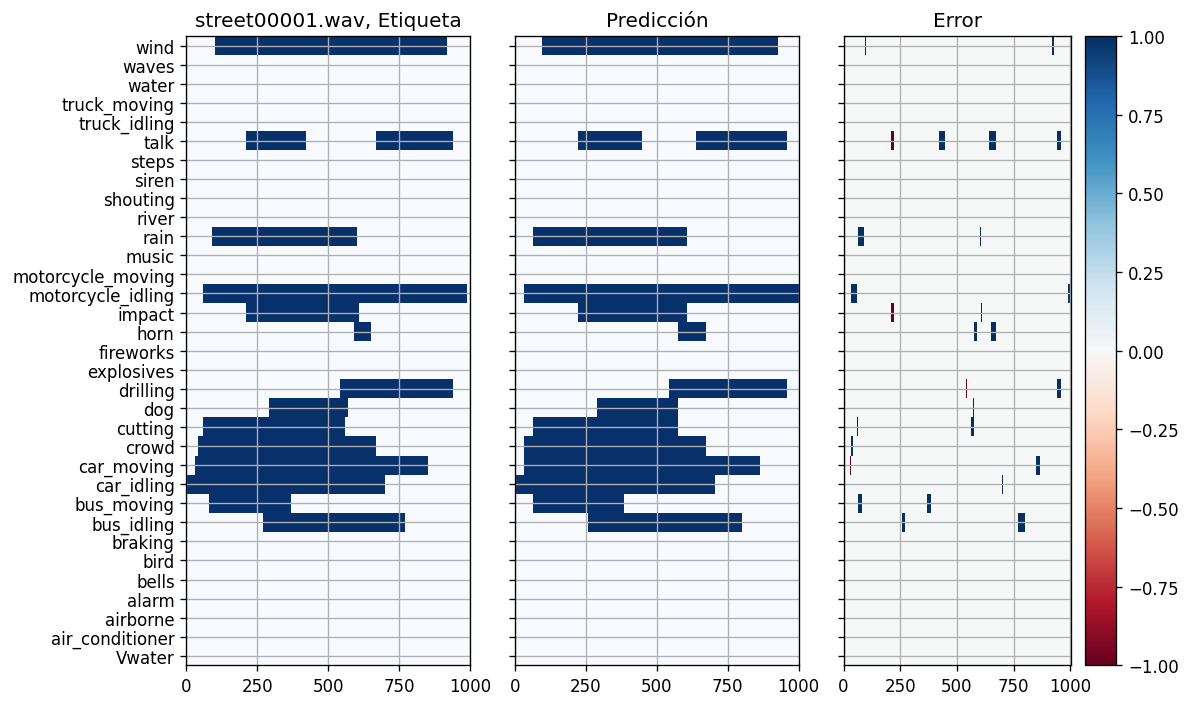

In [2]:
def plot_file_prediction(file_idx: int, th: float=None):
    pred = model.forward(fusa_dataset[file_idx])[0].T.detach().numpy()
    if th is not None:
        pred = pred > th
    label = fusa_dataset[file_idx]['label'].T.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(10, 6), facecolor='w', dpi=120,
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(f"{fusa_dataset[file_idx]['filename']}, Etiqueta")
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(np.arange(0, len(categories), step=1) + 0.5)
    ax[0].set_yticklabels((categories));
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
plot_file_prediction(0, 0.3)

In [3]:
scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
th = 0.3
places, labels, preds = [], [], []
for sample in tqdm(fusa_dataset):
    places.append([key for key, scene in scenarios.items() if scene in sample['filename']][0])
    preds.append(model.forward(sample)[0].T.detach().numpy() > th)
    labels.append(sample['label'].T.numpy())    
places = np.array(places)
preds = np.stack(preds)
labels = np.stack(labels)

  0%|          | 0/100 [00:00<?, ?it/s]

Por clase para todos los ambientes

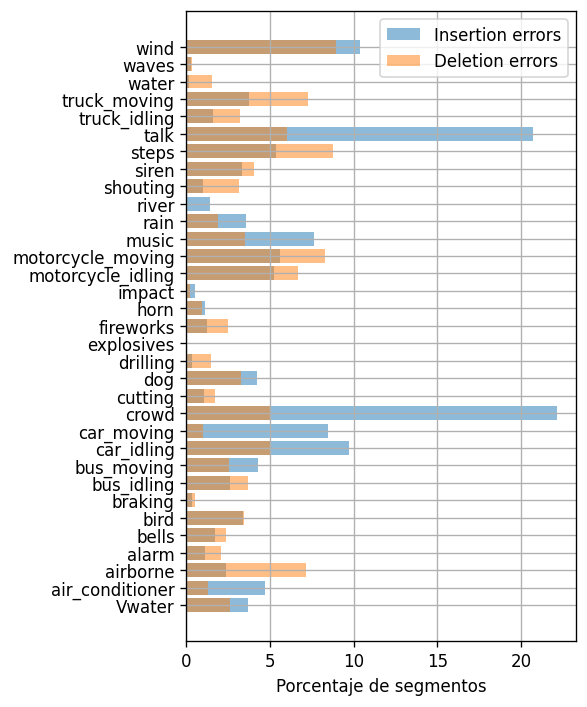

In [4]:
insertions = np.mean((preds==1) & (labels==0), axis=(0, 2))
deletions = np.mean((preds==0) & (labels==1), axis=(0, 2))

fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)
ax.barh(y=list(categories), width=100*insertions, 
        label='Insertion errors', alpha=0.5)
ax.barh(y=list(categories), width=100*deletions,
        label='Deletion errors', alpha=0.5)
ax.legend()
ax.grid()
ax.set_xlabel('Porcentaje de segmentos');

Por ambiente separado por clase:

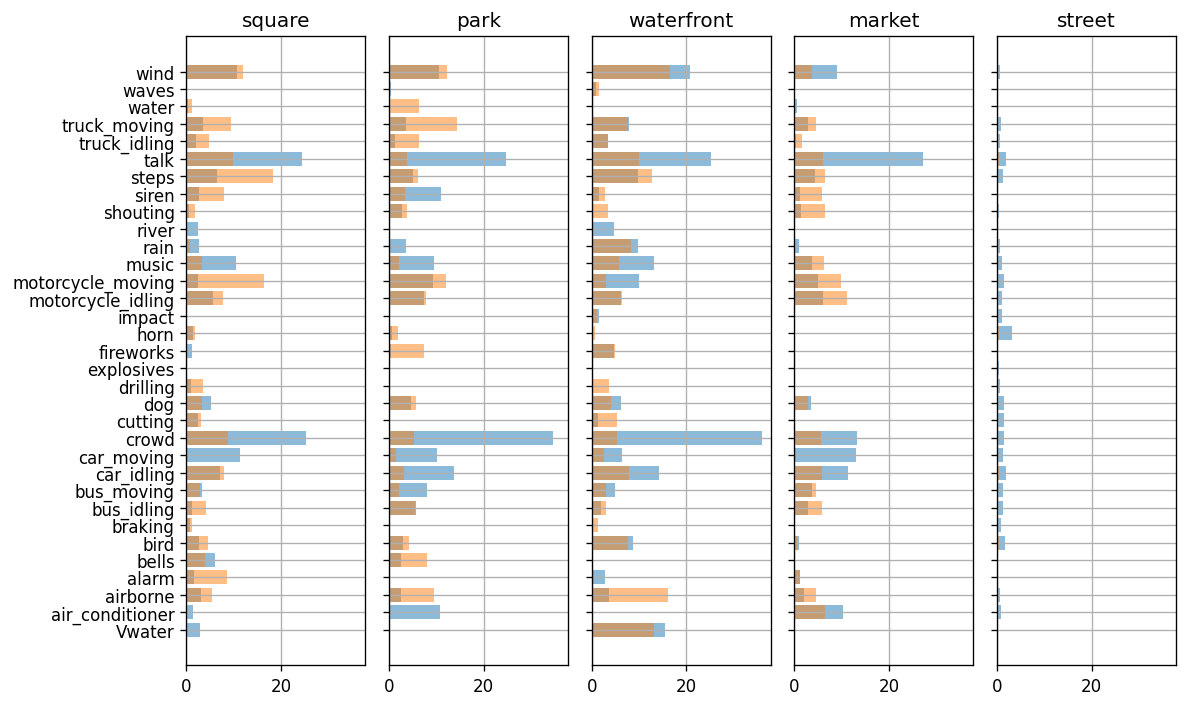

In [5]:
insertions = np.mean(np.stack([(preds[places==place] == 1) & (labels[places==place] == 0) for place in scenarios.keys()]), axis=(1, 3))
deletions = np.mean(np.stack([(preds[places==place] == 0) & (labels[places==place] == 1) for place in scenarios.keys()]), axis=(1, 3))

fig, ax = plt.subplots(1, 5, figsize=(10,  6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)  
for ax_, ins, dels, scene in zip(ax, insertions, deletions, scenarios.values()):
    ax_.barh(y=list(categories), width=100*ins, 
        label='Insertion errors', alpha=0.5)
    ax_.barh(y=list(categories), width=100*dels,
            label='Deletion errors', alpha=0.5)
    ax_.set_title(scene)
    ax_.grid()
#ax_.legend();

Por ambiente:

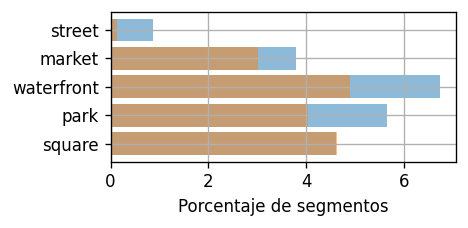

In [6]:
insertions = np.mean(np.stack([(preds[places==place] == 1) & (labels[places==place] == 0) for place in scenarios.keys()]), axis=(1, 2, 3))
deletions = np.mean(np.stack([(preds[places==place] == 0) & (labels[places==place] == 1) for place in scenarios.keys()]), axis=(1, 2, 3))

fig, ax = plt.subplots(figsize=(4, 2), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)
ax.barh(y=list(scenarios.values()), width=100*insertions, 
        label='Ins. errors', alpha=0.5)
ax.barh(y=list(scenarios.values()), width=100*deletions,
        label='Del. errors', alpha=0.5)
#ax.legend()
ax.grid()
ax.set_xlabel('Porcentaje de segmentos');

Por macro clase:

In [7]:
inv_categories = {}
for key, values in enumerate(categories):
    inv_categories[values] = int(key)
    
macro_classes = ['human', 'animal', 'alerts', 'music', 'environmental', 'mechanical', 'vehicle']
fusa_taxonomy = {0: ['crowd', 'shouting', 'talk', 'steps'],
                 1: ['bird', 'dog'], 
                 2: ['siren', 'bells', 'alarm', 'horn', 'braking'],
                 3: ['music'],
                 4: ['rain', 'wind', 'water', 'river', 'waves'],
                 5: ['cutting', 'drilling', 'fireworks', 
                     'impact', 'explosives', 'air_conditioner'],
                 6: ['car_idling', 'car_moving', 'bus_idling', 'bus_moving', 'airborne',
                     'motorcycle_idling', 'motorcycle_moving', 'truck_idling', 'truck_moving', 'Vwater']
                }
fusa_taxonomy_int = {}
for key, values in fusa_taxonomy.items():
    transformed_values = []
    for value in values:
        transformed_values.append(inv_categories[value])
    fusa_taxonomy_int[key] = transformed_values
        
inv_taxonomy = {}
for key, values in fusa_taxonomy_int.items():
    for value in values:
        inv_taxonomy[value] = key

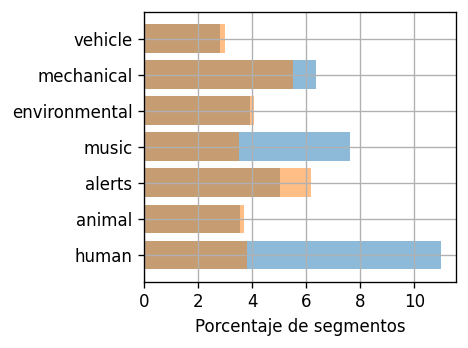

In [8]:
pred_macro = np.stack([np.amax(preds[:, fusa_taxonomy_int[macro], :], axis=1) for macro in range(len(macro_classes))])
label_macro = np.stack([np.amax(labels[:, fusa_taxonomy_int[macro], :], axis=1) for macro in range(len(macro_classes))])

insertions = np.mean((pred_macro == 1) & (label_macro==0), axis=(1, 2))
deletions = np.mean((pred_macro == 0) & (label_macro==1), axis=(1, 2))

fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)
ax.barh(y=macro_classes, width=100*insertions, 
        label='Insertion errors', alpha=0.5)
ax.barh(y=macro_classes, width=100*deletions,
        label='Deletion errors', alpha=0.5)
#ax.legend()
ax.grid()
ax.set_xlabel('Porcentaje de segmentos');

Intercambio entre clase idling y clase moving: